#  MONAI Bootcamp

# Segmentation Exercise  [workspace]
<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>


In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. 
Below is the code for setting up a segmentation network and training it. The network isn't very good, **so the exercise is to improve the quality of the segmentation by improving the network and/or the training scheme including data loading efficiency and data augmentation**. 

The data being used here is derived from the [Sunnybrook Cardiac Dataset](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac MR images, filtered to contain only left ventricular myocardium segmentations and reduced in the XY dimensions.

<img src="https://www.cardiacatlas.org/wp-content/uploads/2015/09/scd-mri.png" width=400>

 

 

## 👉 Challenge: Improve Results and Implementation 👈

### 1. Improve Data Pipeline

The pipeline currently has a very basic set of transforms. We'd want to add new transforms which will add regularization to our training process, specifically modifying the image and segmentations to make the learning problem a little harder. 

The dataset being used is `ArrayDataset` but we have in MONAI `NPZDictItemDataset` for loading data from Numpy's NPZ file format. Change the code to use this class instead. You'll need a different way of getting `caseIndices` and splitting the dataset using it.

### 2. Improve/Replace Network

As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25, which is really poor. 

It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. 

### 3. Replace The Training Loop

This notebook uses a simple training loop with validation done explicitly. Replace this with a use of the `SupervisedTrainer` class and `SupervisedEvaluator` to do the evaluation throughout the training process. The graph plotting is done simply by recording values at each iteration through the loop, you'll want to use some other mechanism to do the same thing such as using a `MetricLogger` handler object.

### Check GPU Support

Running  `!nvidia-smi` in a cell will verify this has worked and show you what kind of hardware you have access to.

if GPU Memory Usage is no `0 MiB` shutdown all kernels and restart current kernel.
- step1. shutdown kernel with following <b>Menu</b> > <b>Kernel</b> > <b>Shut Down All kernels </b>
- step2. restart kernelw with following <b>Menu</b> > <b>Kernel</b> > <b>Restart Kernel</b>


In [1]:
!nvidia-smi

Sat Nov  5 05:27:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:BD:00.0 Off |                   On |
| N/A   30C    P0    62W / 400W |   5142MiB / 81920MiB |     N/A      Default |
|                               |                      |              Enabled |
+-------------------------------+----------------------+----------------------+

+-----------------------------------------------------------------------------+
| MIG d

### Setup imports

In [2]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import torch

from urllib.request import urlopen
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

import monai
from monai.transforms import Compose, AddChannel, ScaleIntensity, ToTensor
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.data import ArrayDataset
from torch.utils.data import DataLoader
from monai.utils import first, progress_bar
from monai.networks import one_hot
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import set_determinism

set_determinism(0)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

## 1. Setting up our Dataset and exploring the data
#### Setup data directory

We'll create a temporary directory for all the MONAI data we're going to be using called temp directory in `~/monai-lab/temp`. 

In [3]:
import os 
import glob
directory = "temp"
if not os.path.exists(directory):
    os.makedirs(directory)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

temp


## download dataset 

We will use preprocessed Sunnybrook Cardiac MRI dataset (2MB) at  [VPH Summer SChool 2019](https://www.vph-institute.org/events/2019-vph-summer-school.html)

You can check for further research
- Sunnybrook Cardiac MRI dataset(30MB) in [kaggle](https://www.kaggle.com/datasets/salikhussaini49/sunnybrook-cardiac-mri)
- Sunnybrook Cardiac Data DICOM file(2.6GB) at [Cardiac Atlas Project](https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/)

In [4]:
device = torch.device("cuda:0")
DATA_NPZ = "https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs.npz"

We now load the data from the remote source and visualize a sample:

In [5]:
%%time
remote_file = urlopen(DATA_NPZ)
npz = BytesIO(remote_file.read())

CPU times: user 28.8 ms, sys: 22.2 ms, total: 51 ms
Wall time: 718 ms


(420, 64, 64) (420, 64, 64)


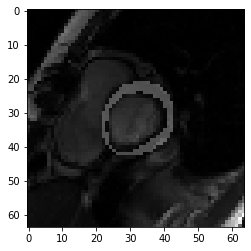

In [6]:
data = np.load(npz)  # load all the data from the archive

images = data["images"]  # images in BHW array order
segs = data["segs"]  # segmentations in BHW array order
case_indices = data["caseIndices"]  # the indices in `images` for each case

images = images.astype(np.float32) / images.max()  # normalize images

print(images.shape, segs.shape)
plt.imshow(images[13] + segs[13] * 0.25, cmap="gray")  # show image 13 with segmentation

We will split our data into a training and validation set by keeping the last 6 cases as the latter:

## Baseline [start]

```
valid_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:valid_index], segs[:valid_index]
valid_images, valid_segs = images[valid_index:], segs[valid_index:]

batch_size = 50
num_workers = 2

image_trans = Compose(
    [
        ScaleIntensity(),  # rescale image data to range [0,1]
        AddChannel(),  # add 1-size channel dimension
        ToTensor(),  # convert to tensor
    ]
)

seg_trans = Compose([AddChannel(), ToTensor()])

ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_ds = ArrayDataset(valid_images, image_trans, valid_segs, seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

im, seg = first(loader)
print(im.shape, im.min(), im.max(), seg.shape)
```

We can now create a MONAI data loading object to compose batches during training, and another for validation:

In [7]:
valid_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:valid_index], segs[:valid_index]
valid_images, valid_segs = images[valid_index:], segs[valid_index:]

In [8]:
batch_size = 30
num_workers = 2

image_trans = Compose(
    [
        ScaleIntensity(),  # rescale image data to range [0,1]
        AddChannel(),  # add 1-size channel dimension
        ToTensor(),  # convert to tensor
    ]
)

seg_trans = Compose([AddChannel(), ToTensor()])

ds = ArrayDataset(train_images, image_trans, train_segs, seg_trans)
loader = DataLoader(
    dataset=ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_ds = ArrayDataset(valid_images, image_trans, valid_segs, seg_trans)
val_loader = DataLoader(
    dataset=val_ds,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

im, seg = first(loader)
print(im.shape, im.min(), im.max(), seg.shape)

torch.Size([30, 1, 64, 64]) tensor(0.) tensor(1.) torch.Size([30, 1, 64, 64])


## Baseline [end]

### 1. Improve Data Pipeline

The pipeline currently has a very basic set of transforms. We'd want to add new transforms which will add regularization to our training process, specifically modifying the image and segmentations to make the learning problem a little harder. 

The dataset being used is `ArrayDataset` but we have in MONAI `NPZDictItemDataset` for loading data from Numpy's NPZ file format. Change the code to use this class instead. You'll need a different way of getting `caseIndices` and splitting the dataset using it.

In [9]:
from monai.transforms import (
    Activationsd, 
    AsDiscreted,
    AddChanneld,
    ScaleIntensityd,
    CastToTyped,
    EnsureTyped,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)


In [10]:
# new imports
from monai.data import  NPZDictItemDataset #TODO  #ArrayDataset  to NPZDictItemDataset

############
batch_size = 30
num_workers = 2
aug_prob = 0.5
############
from monai.transforms import (
    Activationsd, 
    AsDiscreted,
    AddChanneld,
    ScaleIntensityd,
    CastToTyped,
    EnsureTyped,
    RandFlipd,
    RandRotate90d,
    RandZoomd,
    Rand2DElasticd,
    RandAffined,
)


You'll need a different way of getting caseIndices and splitting the dataset using it. In the baseline, We split our data into a training and validation set by keeping the last 6 cases as the latter:

In [9]:
####
# use these when interpolating binary segmentations to ensure values are 0 or 1 only
zoom_mode = monai.utils.enums.InterpolateMode.NEAREST
elast_mode = monai.utils.enums.GridSampleMode.BILINEAR, monai.utils.enums.GridSampleMode.NEAREST

#########
# for keys 
from monai.utils.enums import CommonKeys
both_keys = (None, None) # TODO (CommonKeys.IMAGE, CommonKeys.LABEL)
image_only = None #TODO CommonKeys.IMAGE

In [10]:
train_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        RandRotate90d(keys=both_keys, prob=aug_prob),
        RandFlipd(keys=both_keys, prob=aug_prob),
        RandZoomd(keys=both_keys, prob=aug_prob, mode=zoom_mode),
        Rand2DElasticd(keys=both_keys, prob=aug_prob, spacing=10, magnitude_range=(-2, 2), mode=elast_mode),
#         RandAffined(keys=both_keys, prob=aug_prob, rotate_range=1, translate_range=16, mode=elast_mode),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

val_trans = Compose(
    [
        ScaleIntensityd(image_only),
        AddChanneld(both_keys),
        CastToTyped(both_keys, (np.float32, np.int32)),
        EnsureTyped(both_keys),
    ]
)

We can now create a MONAI data loading object to compose batches during training, and another for validation: However, we need to replace `ArrayDataset` `ArrayDataset(train_images, image_trans, train_segs, seg_trans)` with `NPZDictItemDataset`

check MONAI document for [NPZDictItemDataset](https://docs.monai.io/en/stable/data.html?highlight=NPZDictItemDataset#npzdictitemdataset)

class monai.data.<b>NPZDictItemDataset</b>(`npzfile, keys, transform=None, other_keys=()`)

Represents a dataset from a loaded NPZ file. The members of the file to load are named in the keys of keys and stored under the keyed name. All loaded arrays must have the same 0-dimension (batch) size. Items are always dicts mapping names to an item extracted from the loaded arrays. If passing slicing indices, will return a PyTorch Subset, for example: data: Subset = dataset[1:4], for more details, please check: https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset

Parameters
- <b>npzfile</b> (`Union[str, IO]`) – Path to .npz file or stream containing .npz file data
- <b>keys</b> (`Dict[str, str]`) – Maps keys to load from file to name to store in dataset
- <b>transform</b> (`Optional[Callable[…, Dict[str, Any]]]`) – Transform to apply to batch dict
- <b>other_keys</b> (`Optional[Sequence[str]]`) – secondary data to load from file and store in dict other_keys, not returned by __getitem__
- <b>data</b> – input data to load and transform to generate dataset for model.
- <b>transform</b> – a callable data transform on input data.

In [11]:

# for keys 
from monai.utils.enums import CommonKeys

# create training and validation datasets from the whole set of images, these will be resized below based on case indices

keys_train = {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL} #TODO
keys_val =  {"images": CommonKeys.IMAGE, "segs": CommonKeys.LABEL} # TODO

train_dat = NPZDictItemDataset( npz, keys_train , train_trans  , ("caseIndices",) ) #TODO #ArrayDataset  to NPZDictItemDataset
val_dat   = NPZDictItemDataset( npz, keys_val , val_trans  ) #TODO  #ArrayDataset  to NPZDictItemDataset


NameError: name 'train_trans' is not defined

configure  train_loader and val_loader

In [12]:


# extract the case indices array
case_indices = train_dat.other_keys["caseIndices"] # TODO data["caseIndices"]   to train_dat
val_index = case_indices[-6, 0]  # keep the last 6 cases for testing


train_dat = train_dat[:val_index]
val_dat = val_dat[val_index:]


train_loader = DataLoader(
    dataset=train_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)

val_loader = DataLoader(
    dataset=val_dat,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available(),
)



In [13]:
print(len(train_dat), len(val_dat))
print(len(train_loader), len(val_loader))


368 52
8 2


We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

### Monai Network
MONAI provides predefined networks. we can easily import it. 

- [Layers](https://docs.monai.io/en/stable/networks.html#layers) : Act, Conv, Norm, Dropout, Flatten, Reshape, Pad, Pool, SkipConnection
- [Blocks](https://docs.monai.io/en/stable/networks.html#module-monai.networks.blocks) : ADN, Convolution, Synamic UnetBlock, FCN, GCN, Squeeze-andExcitation, ResNeXt, SABlock, Transformer Block, 
- [Nets](https://docs.monai.io/en/stable/networks.html#nets)  : DenseNet121, EfficientNet, SegResNet, ResNet, SENet154, DyUNet, UNet, AutoEncoder, VarAutoEncoder, ViT, 

We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

# BaseLine Model 

SegNet : 
 - Input 
 - Conv2D
 - MaxPool2D
 - Conv3D
 - ConvT2D
 - Conv2d
 - Output 

<p><img align='left' src="https://miro.medium.com/max/1400/1*nGFy96r63GwSE_EsJDLMDw.png" width=600>  </p>
<br>


```
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # layer 1: convolution, normalization, downsampling
            nn.Conv2d(1, 2, 3, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2, 1),
            # layer 2
            nn.Conv2d(2, 4, 3, 1, 1),
            # layer 3
            nn.ConvTranspose2d(4, 2, 3, 2, 1, 1),
            nn.BatchNorm2d(2),
            nn.ReLU(),
            # layer 4: output
            nn.Conv2d(2, 1, 3, 1, 1),
        )

    def forward(self, x):
        return self.model(x)
    
net = SegNet()
net = net.to(device)

```

## 👉 Challenge: Improve Results and Implementation 👈


### 2. Improve/Replace Network

As you can see we're not getting good results from our network. The training loss values are jumping around and not decreasing much anymore. The validation score has topped out at 0.25, which is really poor. 

It's now up to you to improve the results of our segmentation task. The things to consider changing include the network itself, how data is loaded, how batches might be composed, and what transforms we want to use from MONAI. 

# 2. Model 

### UNet

[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/abs/1505.04597)
U Shaped Network was developed by Olaf Ronneberger et al. for Bio Medical Image Segmentation. 
It is Fully Convolutional Network Model for the segmentation task with two paths(encoder and decoder) with 1x1 convolution skip connection similar as residual. 
<img src="https://miro.medium.com/max/1400/1*J3t2b65ufsl1x6caf6GiBA.png" width=800>

#### UNet in monai.networks
class monai.networks.nets.<b>UNet </b> (`spatial_dims, in_channels, out_channels, channels, strides, kernel_size=3, up_kernel_size=3, num_res_units=0, act='PRELU', norm='INSTANCE', dropout=0.0, bias=True, dimensions=None` )
Enhanced version of <br>UNet</b> which has residual units implemented with the `ResidualUnit` class. The residual part uses a convolution to change the input dimensions to match the output dimensions if this is necessary but will use `nn.Identity` if not. Refer to: [Link](https://link.springer.com/chapter/10.1007/978-3-030-12029-0_40).

Each layer of the network has a encode and decode path with a skip connection between them. Data in the encode path is downsampled using strided convolutions (if strides is given values greater than 1) and in the decode path upsampled using strided transpose convolutions. These down or up sampling operations occur at the beginning of each block rather than afterwards as is typical in <b>UNet</b> implementations.

To further explain this consider the first example network given below. This network has 3 layers with strides of 2 for each of the middle layers (the last layer is the bottom connection which does not down/up sample). Input data to this network is immediately reduced in the spatial dimensions by a factor of 2 by the first convolution of the residual unit defining the first layer of the encode part. The last layer of the decode part will upsample its input (data from the previous layer concatenated with data from the skip connection) in the first convolution. this ensures the final output of the network has the same shape as the input.

Padding values for the convolutions are chosen to ensure output sizes are even divisors/multiples of the input sizes if the strides value for a layer is a factor of the input sizes. A typical case is to use strides values of 2 and inputs that are multiples of powers of 2. An input can thus be downsampled evenly however many times its dimensions can be divided by 2, so for the example network inputs would have to have dimensions that are multiples of 4. In the second example network given below the input to the bottom layer will have shape `(1, 64, 15, 15)` for an input of shape `(1, 1, 240, 240)` demonstrating the input being reduced in size spatially by 2**4.

##### Parameters
 - <b>spatial_dims </b>(`int`)  – number of spatial dimensions.
 - <b>in_channels </b>(`int`) – number of input channels.
 - <b>out_channels </b>(`int`) – number of output channels.
 - <b>channels</b> (`Sequence[int]`) – sequence of channels. Top block first. The length of channels should be no less than 2.
 - <b>strides</b> (`Sequence[int]`) – sequence of convolution strides. The length of stride should equal to len(channels) - 1.
 - <b>kernel_size</b> (`Union[Sequence[int], int]`) – convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>up_kernel_size</b> (`Union[Sequence[int], int]`) – upsampling convolution kernel size, the value(s) should be odd. If sequence, its length should equal to dimensions. Defaults to 3.
 - <b>num_res_units</b>  (`int`)– number of residual units. Defaults to 0.
 - <b>act</b> (`Union[Tuple, str]`) – activation type and arguments. Defaults to PReLU.
 - <b>norm</b> (`Union[Tuple, str]`) – feature normalization type and arguments. Defaults to instance norm.
 - <b>dropout</b> (`float`) – dropout ratio. Defaults to no dropout.
 - <b>bias (`bool`)</b> – whether to have a bias term in convolution blocks. Defaults to True. According to Performance Tuning Guide, if a conv layer is directly followed by a batch norm layer, bias should be False.

In [14]:
from monai.networks.nets import AutoEncoder
from monai.networks.nets import UNet
from monai.networks.layers import Norm

device = torch.device("cuda:0")

net = AutoEncoder( spatial_dims =2, in_channels=1, out_channels=1, channels=(4, 8, 16, 32),  strides=(2, 2, 2, 2), ) 
#net = AutoEncoder( spatial_dims =2, in_channels=1, out_channels=1, channels=(8, 16, 32, 64), strides=(2, 2, 2, 2), )
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[16, 32, 64], strides=[2, 2], num_res_units=2, dropout=0.2) # 3 layers 
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16], strides=[2, 2], num_res_units=2, dropout=0.2) # 3 layers 
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16, 32,64], strides=[2,2, 2,2], num_res_units=3, dropout=0.4) # 5 layers
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[16, 32, 64, 128, 256], strides=[2, 2, 2, 2], num_res_units=4, dropout=0.2) # 5 layers
#net = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=[4, 8, 16, 32,64, 128,256], strides=[2, 2, 2, 2,2,2], num_res_units=6, dropout=0.2) # 7 layers

net = net.to(device)


### loss and metric

In [15]:
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
loss = DiceLoss(sigmoid=True)
metric = DiceMetric(include_background=True, reduction="mean")

### configure optimizer

In [16]:
lr = 3e-3
opt = torch.optim.Adam(net.parameters(), lr)

In [17]:
num_epochs = 200

### train loop [Baseline]

```
step_losses = []
epoch_metrics = []
total_step = 0

print("start train")

for epoch in range(num_epochs):
    net.train()

    # train network with training images
    for bimages, bsegs in loader:
        bimages = bimages.to(device)
        bsegs = bsegs.to(device)

        opt.zero_grad()

        prediction = net(bimages)
        loss_val = loss(torch.sigmoid(prediction), bsegs)
        loss_val.backward()
        opt.step()

        step_losses.append((total_step, loss_val.item()))
        total_step += 1

    net.eval()
    metric_vals = []

    # test our network using the validation dataset
    with torch.no_grad():
        for bimages, bsegs in val_loader:
            bimages = bimages.to(device)
            bsegs = bsegs.to(device)

            #prediction = net(bimages)

            mvals = metric(y_pred=torch.sigmoid(prediction) > 0.5, y=bsegs)
            metric_vals += mvals.cpu().data.numpy().flatten().tolist()

    epoch_metrics.append((total_step, np.average(metric_vals)))

    progress_bar(epoch + 1, num_epochs, f"Validation Metric: {epoch_metrics[-1][1]:7.3}")
```    

We now graph the results from our training and find the results are not very good:

## 👉 Challenge: Improve Results and Implementation 👈

### 3. Replace The Training Loop

This notebook uses a simple training loop with validation done explicitly. Replace this with a use of the `SupervisedTrainer` class and `SupervisedEvaluator` to do the evaluation throughout the training process. The graph plotting is done simply by recording values at each iteration through the loop, you'll want to use some other mechanism to do the same thing such as using a `MetricLogger` handler object.

# 3. Ignite
in the end-to-end pipeline notebook,  we already use   `SupervisedTrainer` and `SupervisedEvaluator`. 
use MedNIST pipeline 03 and 04 for reference code.

In [18]:
step_losses = []
epoch_metrics = []
metric_values = []
iter_losses=[]
batch_sizes=[]
epoch_loss_values =[]
total_step = 0
max_epochs = 200
step = 1

In [19]:
from monai.transforms import Compose, Activationsd, AsDiscreted

post_transform = Compose(
    [Activationsd(keys="pred", sigmoid=True), AsDiscreted(keys=["pred", "label"], threshold_values=True,),]
)

In [20]:
from monai.handlers import StatsHandler, MeanDice, from_engine
from monai.engines import SupervisedEvaluator


evaluator = SupervisedEvaluator(
    device= device, #TODO
    val_data_loader= val_loader, #TODO
    network=net , #TODO
    postprocessing= post_transform, #TODO
    key_val_metric={"val_mean_dice": MeanDice(include_background=True, output_transform=from_engine(["pred", "label"]))},
    val_handlers=[StatsHandler(output_transform=lambda x: None)],
)


In [21]:
from monai.handlers import MetricLogger, ValidationHandler
from monai.engines import SupervisedTrainer

logger = MetricLogger(evaluator=evaluator)

trainer = SupervisedTrainer(
    device= device, #TODO
    max_epochs= max_epochs,  #TODO
    train_data_loader= train_loader,  #TODO
    network= net,  #TODO
    optimizer= opt,  #TODO
    loss_function= loss,  #TODO
    train_handlers=[logger, ValidationHandler(1, evaluator)],
)

steps_per_epoch = len(train_dat) // train_loader.batch_size
if len(train_dat) % train_loader.batch_size != 0:
    steps_per_epoch += 1
print(len(train_dat) , train_loader.batch_size, steps_per_epoch)

368 50 8


In [22]:
from ignite.engine import Engine, Events

@trainer.on(Events.ITERATION_COMPLETED)
def _end_iter(engine: Engine):
    global step
    loss = np.average([o["loss"] for o in engine.state.output])
    batch_len = len(engine.state.batch[0])
    epoch = engine.state.epoch
    epoch_len = engine.state.max_epochs
    step_total = engine.state.iteration  
    iter_losses.append(loss)
    batch_sizes.append(batch_len)

    print(f"\nepoch {epoch}/{epoch_len}, step {step}/{steps_per_epoch},  total step {step_total}/{steps_per_epoch*epoch_len}, training_loss = {loss:.4f}", end='')
    step += 1
    

@trainer.on(Events.EPOCH_COMPLETED)
def _end_epoch(engine: Engine):
    global step
    overall_average_loss = np.average(iter_losses, weights=batch_sizes)
    epoch_loss_values.append(overall_average_loss)    
    # clear the contents of iter_losses and batch_sizes for the next epoch
    del iter_losses[:]
    del batch_sizes[:]
    
    dice = evaluator.state.metrics["val_mean_dice"]   
    metric_values.append(dice)
    #progress_bar(engine.state.epoch, num_epochs, f"Validation Metric: {dice:7.3}")
    print(f" | avg loss: {overall_average_loss:.4f} Dice Metric: {dice:7.3}", end='')
    step = 1



In [ ]:
trainer.run()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
 
ax[0].plot(epoch_loss_values)
ax[0].set_title("epoch Loss")
ax[0].set_ylim(0,1)
ax[1].plot(metric_values)
ax[1].set_title("epoch matric")
ax[1].set_ylim(0,1)
plt.show()

# repeat trials 




## Navigation
- [01_getting started](./01_getting.ipynb)

- [02_pipeline_01](./02_pipeline_01.ipynb)
- [02_pipeline_02 ](./02_pipeline_02.ipynb)
- [02_pipeline_03](./02_pipeline_03.ipynb)
- [02_pipeline_04 Next ](./02_pipeline_04.ipynb)

- [03_brain_gan ](./03_brain_gan_01.ipynb)

- [04_spleen_segment](./04_spleen_segment.ipynb) 

- [05_challenge_cardiac baseline](./05_challenge_cardiac_baseline.ipynb) 

- [05_challenge_cardiac workspace](./05_challenge_cardiac_workspace.ipynb) 

<img src="https://github.com/Project-MONAI/MONAIBootcamp2021/raw/2f28b64f814a03703667c8ea18cc84f53d6795e4/day1/monai.png" width=400>